In [1]:
!nvidia-smi

Thu Feb 22 16:20:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
! pip install geopandas
! pip install shapely
! pip install rasterio
! pip install patchify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 52.0 MB/s eta 0:00:00


In [3]:
import tensorflow as tf

from typing import List, Any, Tuple
import glob
import numpy as np
import geopandas as gpd

import rasterio
import rasterio as rio
from rasterio.features import shapes
from rasterio import mask
from rasterio.io import MemoryFile
from rasterio.windows import transform, Window
from rasterio.features import dataset_features
from rasterio.transform import from_origin

from skimage import exposure
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd

from rasterio.plot import reshape_as_image
from rasterio.features import rasterize

from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import random
import cv2
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from PIL import Image
from skimage import io
from patchify import patchify, unpatchify

from tensorflow.python.keras.callbacks  import (ReduceLROnPlateau, CSVLogger, ModelCheckpoint, EarlyStopping)

In [4]:
#helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-22 16:21:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-22 16:21:30 (82.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/train.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 767, 'height': 668, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.388124855798503e-05, 0.0, 47.50594338782057,
       0.0, -1.3878893913765135e-05, 41.090411991945984), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}


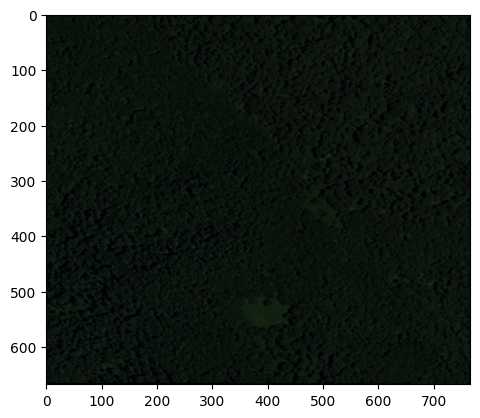

In [8]:
raster_file_path: str = "/content/train/sample_1.tif"
with rasterio.open(raster_file_path, mode='r') as src:
    # Information about the raster data
    print(src.profile)

    img = (src.read([1, 2, 3]).transpose([1,2,0])/4095*255).astype(int)
    plt.imshow(img)

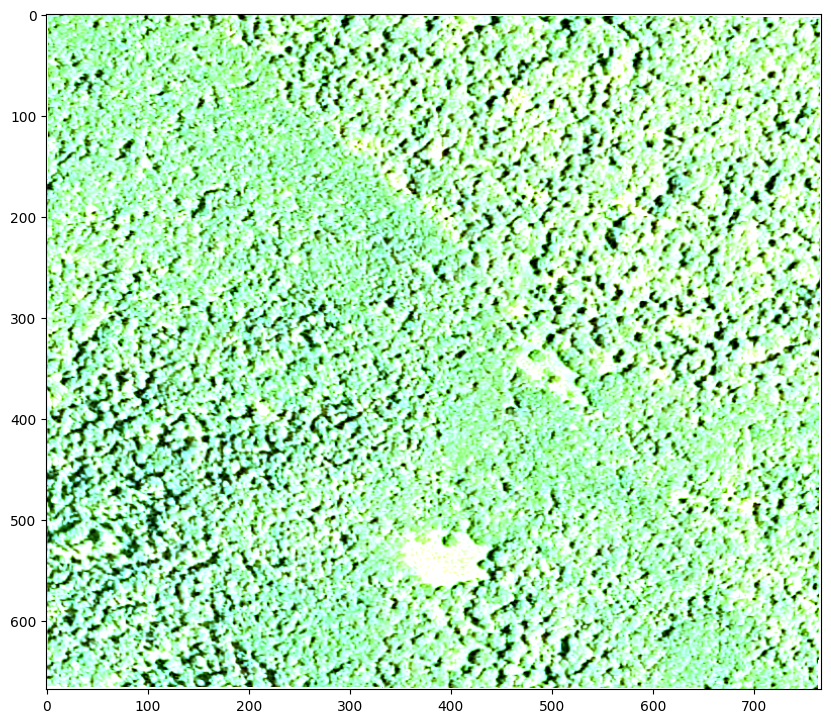

In [9]:
with rasterio.open(raster_file_path, "r") as src:
    raster_image = src.read()
    raster_meta = src.meta

raster_img = reshape_as_image(raster_image)
plt.figure(figsize=(10, 10))
plt.imshow(raster_img)

In [10]:
def read_vector_file(shp_path: str) -> gpd.GeoDataFrame:
    """Read vector file and return GeoPandas Dataframe.

    Args:
        shp_path: Vector file path.
S
    Returns:
        shp: GeoPandas DataFrame.

    """
    return gpd.read_file(shp_path, mode='r')

def convert_vector_to_array(vectorfile: gpd.GeoDataFrame) -> np.ndarray:
    """Convert vector file to the array of geometry objects.

    Args:
        vectorfile: Geopandas dataframe.

    Returns:
        np.ndarray: Array of geometry objects (e.g.: polygons, multipolygons).

    """
    return np.array(vectorfile["geometry"].values)

def mask_raster(raster: rasterio.io.DatasetReader, geometry_objects: np.ndarray) -> Tuple[Any, Any]:
    """Generate binary mask from raster and array of geometry objects.

    Args:
        raster: Raster object.
        geometry_objects: Array of geometry_objects.

    Returns: Tuple[np.array: binary mask array, aff: affine.Affine]

    """
    return mask.raster_geometry_mask(raster, geometry_objects, invert=True)

In [11]:
vector_file_path = '/content/train/sample_1.shp'
vector_file = read_vector_file(vector_file_path)
vector_file

,id,geometry
0,None,"POLYGON ((47.50597 41.09041, 47.51659 41.09038..."


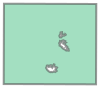

In [12]:
vector_file['geometry'][0]

In [13]:
geometry_objects = convert_vector_to_array(vector_file)
binary_mask, _, _ = mask_raster(src, geometry_objects)

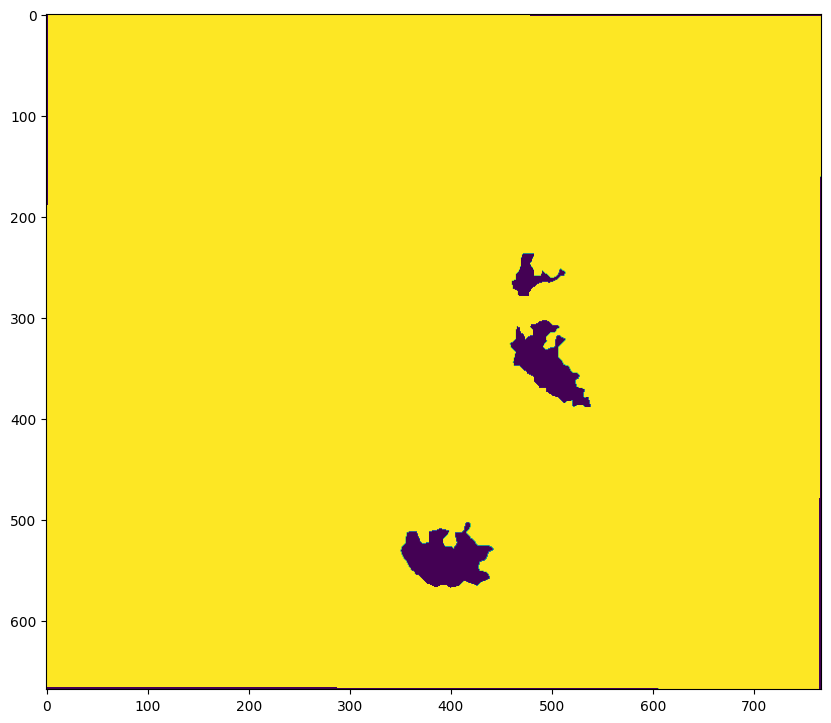

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(binary_mask)

### Convert Shp to binary mask and then .tif file

In [15]:
shp_dir = "/content/train"
output_dir = "/content"

# Step 2: Get the list of .tif files
shp_files = sorted(glob.glob(os.path.join(shp_dir, "*.shp")))

# Create the output directory

output_subdir = os.path.join(output_dir, 'mask')
os.makedirs(output_subdir, exist_ok=True)

for shp_file in shp_files:
  filename = os.path.splitext(os.path.basename(shp_file))[0]
  raster_file_path = os.path.join(shp_dir, f"{filename}.tif")
  with rasterio.open(raster_file_path, "r") as src:
    raster_image = src.read()
    raster_meta = src.meta

  vector_file_path = os.path.join(shp_dir, f"{filename}.shp")
  vector_file = read_vector_file(vector_file_path)

  geometry_objects = convert_vector_to_array(vector_file)
  binary_mask, _, _ = mask_raster(src, geometry_objects)


  output_file_path = os.path.join(output_subdir, f"mask_{filename}.tif")
  mask_array = binary_mask+0
  # Specify the size and resolution of the output raster image
  width = mask_array.shape[1]  # Width of the raster image
  height = mask_array.shape[0]# Height of the raster image
  resolution = 1.0  # Spatial resolution of the raster image

  # Create a new raster dataset using rasterio
  with rasterio.open(output_file_path, 'w', driver='GTiff', dtype=rasterio.uint8,
                   count=1, width=width, height=height, transform=from_origin(0, 0, resolution, resolution)) as dst:
                   dst.write(mask_array.astype(rasterio.uint8), 1)  # Write the mask array as a single-band raster image



/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferenced

#Split images into smaller Patches

In [16]:
def crop_raster(raster_file_path: str, dest_raster_path: str, window: Window ) -> None:
    """Write raster to disk.

    Args:
        raster_file_path: Path of the raster file to be cropped.
        dest_raster_path: Destination Path of the cropped raster file.

    """
    with rasterio.open(raster_file_path) as src:
      profile_copy = src.profile.copy()
      # To crop, you need to set new shape (H(eight) & W(idth)) and coordinates to the raster image to be created.
      profile_copy.update({
          'height': window.height,
          'width': window.width,
          'transform': rasterio.windows.transform(window, src.transform)})
      # Write new raster to the disk
      with rasterio.open(dest_raster_path, 'w', **profile_copy) as dst:
        dst.write(src.read(window=window))



patch_size = 128
scaler = MinMaxScaler()
image_dataset = []
for path,subdirs,files in os.walk('/content/train'):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'train':
        images = sorted(os.listdir(path))
        print(images)
        for i, image_name in enumerate(images):
            if image_name.endswith(".tif"):

                with rasterio.open(path+"/"+image_name, "r") as src:
                  image = src.read([1, 2, 3]).transpose([1,2,0])

                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                window = Window(col_off=0, row_off=0, width=SIZE_X, height=SIZE_Y)
                crop_raster(path+"/"+image_name, 'cropped_path_.tif' ,window)

                with rasterio.open('/content/cropped_path_.tif', "r") as src:
                  image = src.read([1, 2, 3]).transpose([1,2,0])

                image = np.array(image)

                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i,j,0,:,:]

                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                        image_dataset.append(single_patch_img)


['sample_1.dbf', 'sample_1.prj', 'sample_1.shp', 'sample_1.shx', 'sample_1.tif', 'sample_10.dbf', 'sample_10.prj', 'sample_10.shp', 'sample_10.shx', 'sample_10.tif', 'sample_11.dbf', 'sample_11.prj', 'sample_11.shp', 'sample_11.shx', 'sample_11.tif', 'sample_12.dbf', 'sample_12.prj', 'sample_12.shp', 'sample_12.shx', 'sample_12.tif', 'sample_13.dbf', 'sample_13.prj', 'sample_13.shp', 'sample_13.shx', 'sample_13.tif', 'sample_14.dbf', 'sample_14.prj', 'sample_14.shp', 'sample_14.shx', 'sample_14.tif', 'sample_15.dbf', 'sample_15.prj', 'sample_15.shp', 'sample_15.shx', 'sample_15.tif', 'sample_16.dbf', 'sample_16.prj', 'sample_16.shp', 'sample_16.shx', 'sample_16.tif', 'sample_17.dbf', 'sample_17.prj', 'sample_17.shp', 'sample_17.shx', 'sample_17.tif', 'sample_18.dbf', 'sample_18.prj', 'sample_18.shp', 'sample_18.shx', 'sample_18.tif', 'sample_19.dbf', 'sample_19.prj', 'sample_19.shp', 'sample_19.shx', 'sample_19.tif', 'sample_2.dbf', 'sample_2.prj', 'sample_2.shp', 'sample_2.shx', 'samp

In [17]:
mask_dataset = []
for path, subdirs, files in os.walk('/content/mask'):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'mask':
        masks = sorted(os.listdir(path))
        print(masks)
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".tif"):

                mask = cv2.imread(path+'/'+mask_name,1)

                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 1), step=patch_size)

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i,j,0,:,:]
                        mask_dataset.append(single_patch_mask)

['mask_sample_1.tif', 'mask_sample_10.tif', 'mask_sample_11.tif', 'mask_sample_12.tif', 'mask_sample_13.tif', 'mask_sample_14.tif', 'mask_sample_15.tif', 'mask_sample_16.tif', 'mask_sample_17.tif', 'mask_sample_18.tif', 'mask_sample_19.tif', 'mask_sample_2.tif', 'mask_sample_20.tif', 'mask_sample_3.tif', 'mask_sample_4.tif', 'mask_sample_5.tif', 'mask_sample_6.tif', 'mask_sample_7.tif', 'mask_sample_8.tif', 'mask_sample_9.tif']


In [18]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [19]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (898, 128, 128, 3)
Mask data shape is:  (898, 128, 128, 1)
Max pixel value in image is:  1.0000000000000002
Labels in the mask are :  [0 1]


In [20]:
np.unique(mask_dataset, return_counts=True)

(array([0, 1], dtype=uint8), array([ 4635759, 10077073]))

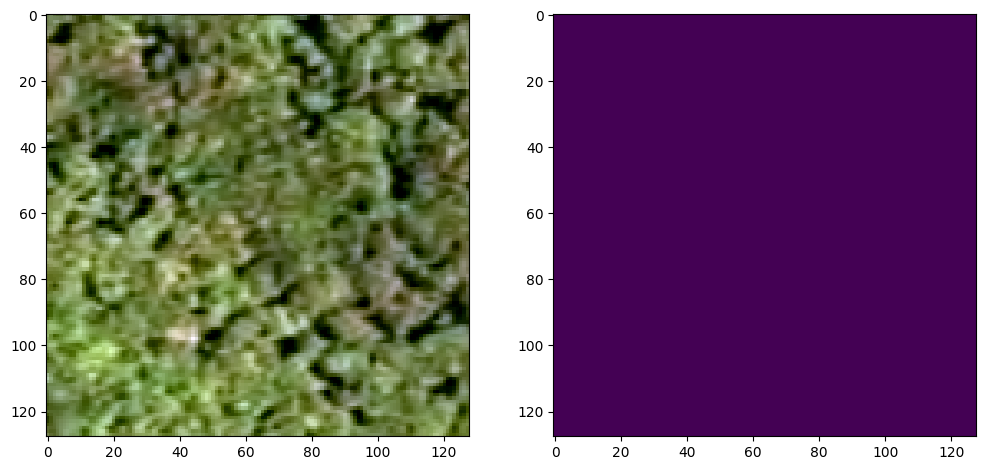

In [72]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.1, random_state = 42)


# Unet Model

In [23]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes, filters=32):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [24]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [25]:
#Metrics
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(tf.cast(y_true, tf.float32))
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [26]:
# save best model with maximum validation accuracy
model_checkpoint_filepath = "weights.best.hdf5"
checkpoint = ModelCheckpoint(model_checkpoint_filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
# stop model training early if validation loss doesn't continue to decrease over 10 iterations
early_stopping = EarlyStopping(monitor="val_loss", patience=20, verbose=1)

# create list of callbacks
callbacks_list = [reduce_lr, checkpoint, early_stopping]  # early_stopping


unet_model = build_unet(input_shape, n_classes=1)
unet_model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['batch_normalizat

In [27]:
unet_model.compile(optimizer=Adam(learning_rate = 1e-3),
                   loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True,gamma=2), metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

unet_history = unet_model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=60,
                    validation_data=(X_test, y_test),
                    shuffle=False , callbacks=callbacks_list)

Epoch 1/60
51/51 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.8499 - auc: 0.9343
Epoch 00001: val_accuracy improved from -inf to 0.30516, saving model to weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 72s 654ms/step - loss: 0.0361 - accuracy: 0.8499 - auc: 0.9343 - val_loss: 0.8581 - val_accuracy: 0.3052 - val_auc: 0.5558 - lr: 0.0010
Epoch 2/60
51/51 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.8991 - auc: 0.9677
Epoch 00002: val_accuracy did not improve from 0.30516
51/51 [==============================] - 12s 244ms/step - loss: 0.0245 - accuracy: 0.8991 - auc: 0.9677 - val_loss: 2.1159 - val_accuracy: 0.3052 - val_auc: 0.5031 - lr: 0.0010
Epoch 3/60
51/51 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9249 - auc: 0.9793
Epoch 00003: val_accuracy did not improve from 0.30516
51/51 [==============================] - 12s 244ms/step - loss: 0.0196 - accuracy: 0.9249 - auc: 0.9793 - val_loss: 0.9565 - val_accuracy: 0.3052 - val_auc: 0.5252 - lr: 0.0010
Epoch 4/60
51/51 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9278 - auc: 0.9827
Epoch 00004: val_accuracy improved 

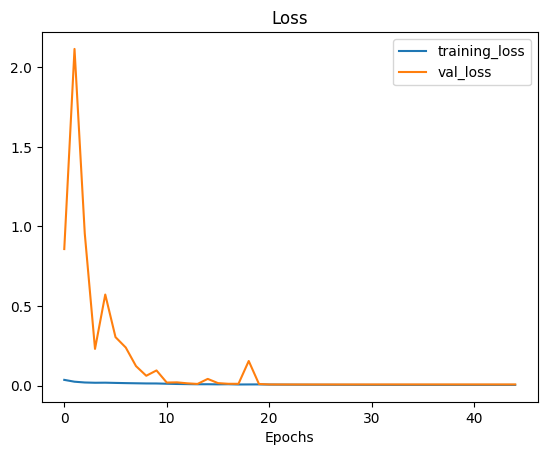

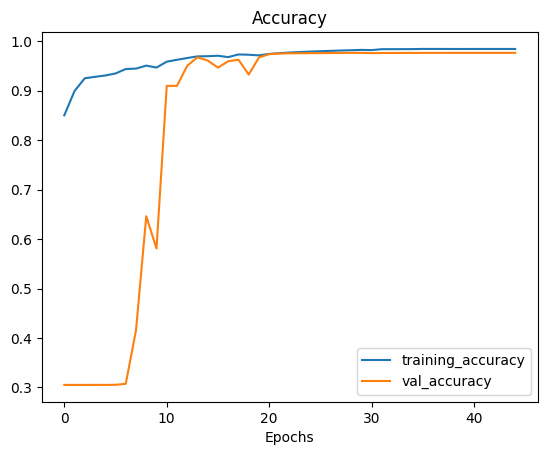

In [28]:
from helper_functions import plot_loss_curves
plot_loss_curves(unet_history)

In [29]:
#IOU
y_pred=unet_model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

3/3 [==============================] - 17s 4s/step


In [30]:
from tensorflow.keras.metrics import MeanIoU
def calculate_MeanIou(y_pred_thresholded, y_test):
  IOU_keras = MeanIoU(num_classes=2)
  IOU_keras.update_state(y_pred_thresholded, y_test)
  model_results = {"Mean IoU": IOU_keras.result().numpy()}
  return model_results

In [31]:
unet_model_result = calculate_MeanIou(y_pred_thresholded, y_test)
unet_model_result

{'Mean IoU': 0.94601846}

In [32]:
def plot_predicted_image(X_test, y_test, model, threshold = 0.5):
  test_img_number = random.randint(0, len(X_test)-1)
  test_img = X_test[test_img_number]
  ground_truth=y_test[test_img_number]
  test_img_input=np.expand_dims(test_img, 0)
  print(test_img_input.shape)
  prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
  print(prediction.shape)

  plt.figure(figsize=(16, 8))
  plt.subplot(241)
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,0])
  plt.subplot(242)
  plt.title('Testing Label')
  plt.imshow(ground_truth[:,:,0])
  plt.subplot(243)
  plt.title('Prediction on test image')
  plt.imshow(prediction)
  plt.subplot(244)
  plt.title('Error')
  error = (ground_truth[:,:,0] != prediction) & (ground_truth[:,:,0] != 0)
  error = error.astype(int)
  plt.imshow(error)

  plt.show()

(1, 128, 128, 3)
1/1 [==============================] - 2s 2s/step
(128, 128)


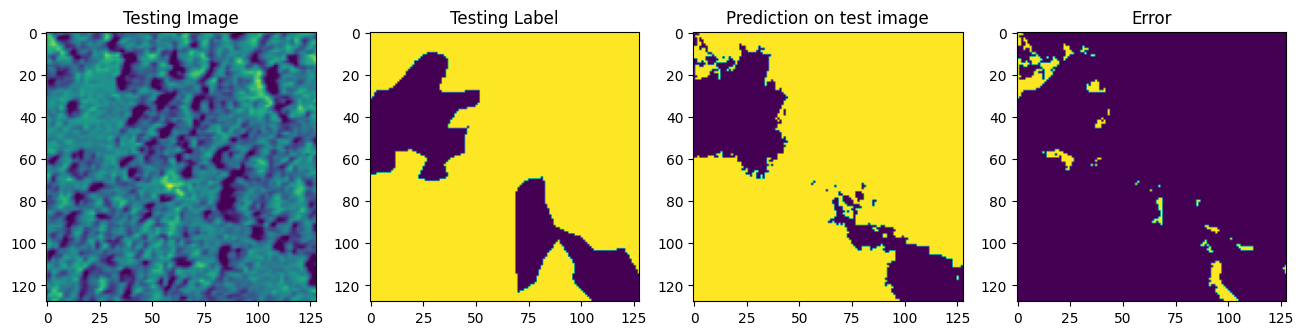

In [33]:
plot_predicted_image(X_test, y_test, unet_model)

In [34]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                 classes= np.array([0,1]),
#                                                 y= y_train.ravel())
# class_weights = dict(zip(np.unique(y_train.ravel()), class_weights))

# Mobilenetv2_Unet

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2



def decoder_block(x, y, filters):
    x = UpSampling2D()(x)
    x = Concatenate(axis = 3)([x,y])
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    return x

def mobilenetv2_unet(input_shape, *, classes, dropout):
    inputs = Input(shape=input_shape)
    """ Pre-trained MobileNetV2 """
    encoder = MobileNetV2(include_top=False, weights="imagenet",
        input_tensor=inputs, alpha=0.35)

    """ Encoder """
    s1 = encoder.get_layer(index=0).output
    s2 = encoder.get_layer("block_1_expand_relu").output
    s3 = encoder.get_layer("block_3_expand_relu").output
    s4 = encoder.get_layer("block_6_expand_relu").output


    x = encoder.get_layer("block_13_expand_relu").output

    """ Decoder """
    x = decoder_block(x, s4, 512)
    x = decoder_block(x, s3, 256)
    x = decoder_block(x, s2, 128)
    x = decoder_block(x, s1, 64)

    x = Dropout(dropout)(x)
    outputs = Conv2D(classes, 1, activation="sigmoid")(x)

    model = Model(inputs, outputs, name="MobileNetV2_U-Net")
    return model

In [36]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [37]:
mobilenetv2_unet_model = mobilenetv2_unet(input_shape,classes=1,dropout = 0.2)

mobilenetv2_unet_model.summary()

2019640/2019640 [==============================] - 0s 0us/step
Model: "MobileNetV2_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 16)           432       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 16)           64        ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU) 

In [38]:
mobilenetv2_unet_model.compile(optimizer=Adam(learning_rate = 1e-3),
                   loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True,gamma=2), metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

mobilenetv2_unet_history = mobilenetv2_unet_model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs=60,
                    validation_data=(X_test, y_test),
                    shuffle=False, callbacks=callbacks_list)

Epoch 1/60
26/26 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.8958 - auc: 0.9621
Epoch 00001: val_accuracy did not improve from 0.97631
26/26 [==============================] - 65s 770ms/step - loss: 0.0298 - accuracy: 0.8958 - auc: 0.9621 - val_loss: 6.1994 - val_accuracy: 0.9401 - val_auc: 0.9103 - lr: 0.0010
Epoch 2/60
26/26 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9537 - auc: 0.9916
Epoch 00002: val_accuracy did not improve from 0.97631
26/26 [==============================] - 9s 359ms/step - loss: 0.0131 - accuracy: 0.9537 - auc: 0.9916 - val_loss: 0.7625 - val_accuracy: 0.9463 - val_auc: 0.9432 - lr: 0.0010
Epoch 3/60
26/26 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9663 - auc: 0.9948
Epoch 00003: val_accuracy did not improve from 0.97631
26/26 [==============================] - 9s 349ms/step - loss: 0.0099 - accuracy: 0.9663 - auc: 0.9948 - val_loss: 0.5261 - val_accuracy: 0.9320 - val_auc: 0.

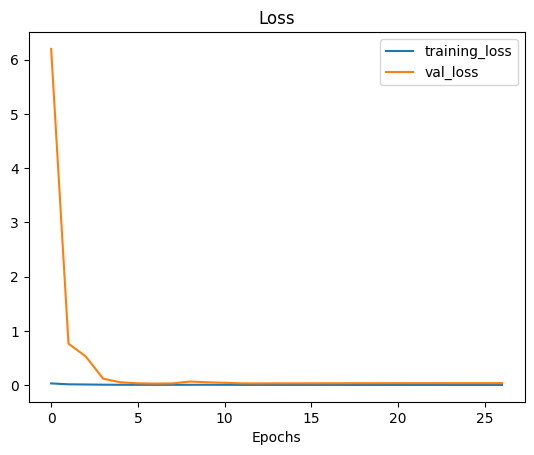

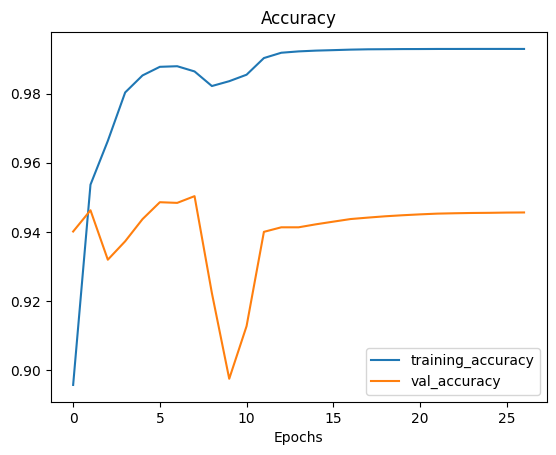

In [39]:
plot_loss_curves(mobilenetv2_unet_history)

In [40]:
#IOU
y_pred=mobilenetv2_unet_model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

3/3 [==============================] - 1s 104ms/step


In [41]:
mobilenetv2_unet_result = calculate_MeanIou(y_pred_thresholded, y_test)
mobilenetv2_unet_result

{'Mean IoU': 0.88338435}

(1, 128, 128, 3)
1/1 [==============================] - 1s 1s/step
(128, 128)


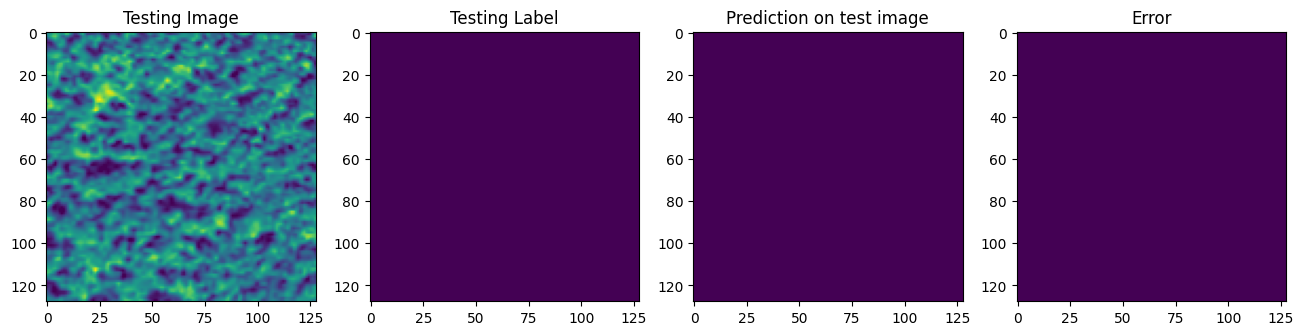

In [42]:
plot_predicted_image(X_test, y_test, mobilenetv2_unet_model)

# MobileUnet

In [43]:
from keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose
from keras.layers import concatenate, Conv2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import Model
from keras.optimizers import Adam

def mobileunet(input_size, num_classes):
    inputs = Input(input_size)

    conv1  = SeparableConv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1  = BatchNormalization()(conv1)
    conv1  = SeparableConv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1  = BatchNormalization()(conv1)
    pool1  = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2  = SeparableConv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2  = BatchNormalization()(conv2)
    conv2  = SeparableConv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2  = BatchNormalization()(conv2)
    pool2  = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3  = SeparableConv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3  = BatchNormalization()(conv3)
    conv3  = SeparableConv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3  = BatchNormalization()(conv3)
    pool3  = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4  = SeparableConv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4  = BatchNormalization()(conv4)
    conv4  = SeparableConv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4  = BatchNormalization()(conv4)
    pool4  = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5  = SeparableConv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5  = BatchNormalization()(conv5)
    conv5  = SeparableConv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5  = BatchNormalization()(conv5)

    conv6  = Conv2DTranspose(512, 3, strides=(2, 2), activation='relu', padding='same')(conv5)
    cat6   = concatenate([conv4, conv6], axis = 3)
    conv6  = SeparableConv2D(512, 3, activation='relu', padding='same')(cat6)
    conv6  = BatchNormalization()(conv6)
    conv6  = SeparableConv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6  = BatchNormalization()(conv6)

    conv7  = Conv2DTranspose(256, 3, strides=(2, 2), activation='relu', padding='same')(conv6)
    cat7   = concatenate([conv3, conv7], axis = 3)
    conv7  = SeparableConv2D(256, 3, activation='relu', padding='same')(cat7)
    conv7  = BatchNormalization()(conv7)
    conv7  = SeparableConv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7  = BatchNormalization()(conv7)

    conv8  = Conv2DTranspose(128, 3, strides=(2, 2), activation='relu', padding='same')(conv7)
    cat8   = concatenate([conv2, conv8], axis = 3)
    conv8  = SeparableConv2D(128, 3, activation='relu', padding='same')(cat8)
    conv8  = BatchNormalization()(conv8)
    conv8  = SeparableConv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8  = BatchNormalization()(conv8)

    conv9  = Conv2DTranspose(64, 3, strides=(2, 2), activation='relu', padding='same')(conv8)
    cat9   = concatenate([conv1, conv9], axis = 3)
    conv9  = SeparableConv2D(64, 3, activation='relu', padding='same')(cat9)
    conv9  = BatchNormalization()(conv9)
    conv9  = SeparableConv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9  = BatchNormalization()(conv9)
    conv9  = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = Conv2D(num_classes, 1, activation='sigmoid')(conv9)

    output = conv10
    return Model(inputs, output)

In [44]:
mobileunet_model = mobileunet(input_shape ,num_classes = 1)

mobileunet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 separable_conv2d (Separabl  (None, 128, 128, 64)         283       ['input_3[0][0]']             
 eConv2D)                                                                                         
                                                                                                  
 batch_normalization_26 (Ba  (None, 128, 128, 64)         256       ['separable_conv2d[0][0]']    
 tchNormalization)                                                                                
                                                                                              

In [45]:
mobileunet_model.compile(optimizer=Adam(learning_rate = 1e-3),
                   loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True,gamma=2), metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

mobileunet_history = mobileunet_model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs=60,
                    validation_data=(X_test, y_test),
                    shuffle=False, callbacks=callbacks_list)

Epoch 1/60
26/26 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.8100 - auc: 0.8854
Epoch 00001: val_accuracy did not improve from 0.97631
26/26 [==============================] - 44s 790ms/step - loss: 0.0508 - accuracy: 0.8100 - auc: 0.8854 - val_loss: 0.0709 - val_accuracy: 0.6948 - val_auc: 0.4994 - lr: 0.0010
Epoch 2/60
26/26 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9277 - auc: 0.9705
Epoch 00002: val_accuracy did not improve from 0.97631
26/26 [==============================] - 11s 405ms/step - loss: 0.0239 - accuracy: 0.9277 - auc: 0.9705 - val_loss: 0.0734 - val_accuracy: 0.6948 - val_auc: 0.4994 - lr: 0.0010
Epoch 3/60
26/26 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9424 - auc: 0.9817
Epoch 00003: val_accuracy did not improve from 0.97631
26/26 [==============================] - 10s 397ms/step - loss: 0.0188 - accuracy: 0.9424 - auc: 0.9817 - val_loss: 0.0762 - val_accuracy: 0.6948 - val_auc: 

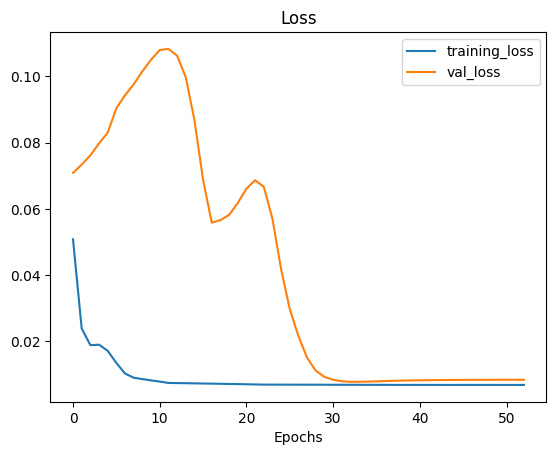

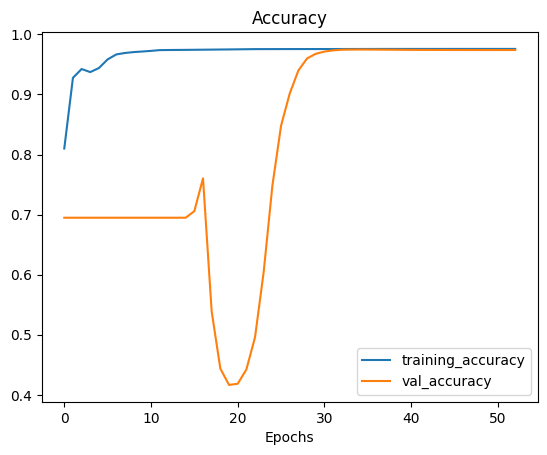

In [46]:
plot_loss_curves(mobileunet_history)

In [47]:
#IOU
y_pred=mobileunet_model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

3/3 [==============================] - 1s 117ms/step


In [48]:
mobileunet_model_result = calculate_MeanIou(y_pred_thresholded, y_test)
mobileunet_model_result

{'Mean IoU': 0.9407925}

(1, 128, 128, 3)
1/1 [==============================] - 0s 21ms/step
(128, 128)


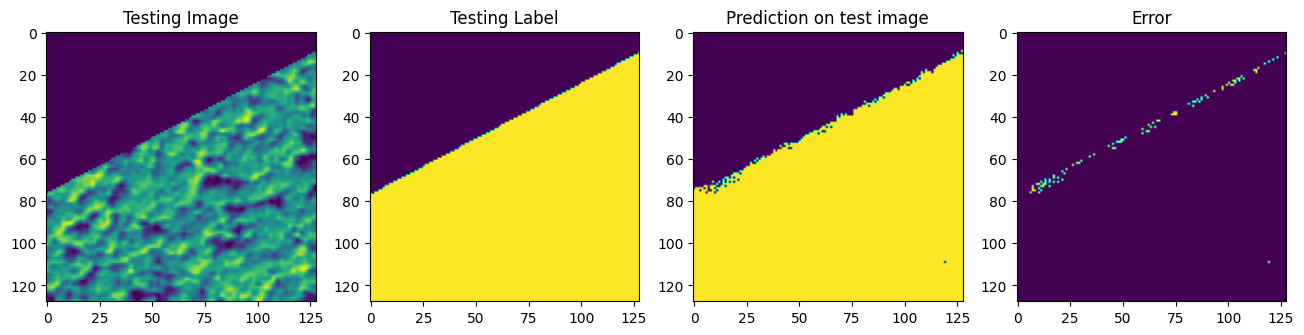

In [56]:
plot_predicted_image(X_test, y_test, mobileunet_model)

# Final Results

In [50]:
all_model_results = pd.DataFrame({ "Unet Model": unet_model_result,
                                   "Mobilenetv2 Unet": mobilenetv2_unet_result ,
                                   "MobileUnet": mobileunet_model_result })

all_model_results = all_model_results.transpose()

all_model_results


,Mean IoU
Unet Model,0.946018
Mobilenetv2 Unet,0.883384
MobileUnet,0.940793


# Predicting test image

In [57]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/test.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [58]:
test_image_dataset = []
test_path = '/content/test/test.tif'
with rasterio.open(test_path, "r") as src:
  image = src.read([1, 2, 3]).transpose([1,2,0])

SIZE_X = (image.shape[1]//patch_size)*patch_size
SIZE_Y = (image.shape[0]//patch_size)*patch_size
window = Window(col_off=0, row_off=0, width=SIZE_X, height=SIZE_Y)
crop_raster(test_path, 'cropped_path_.tif' ,window)

with rasterio.open('/content/cropped_path_.tif', "r") as src:
  image = src.read([1, 2, 3]).transpose([1,2,0])

image = np.array(image)

patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    single_patch_img = patches_img[i,j,0,:,:]
    #print(patches_img[i,j,0,:,:].max())
    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

    test_image_dataset.append(single_patch_img)

In [59]:
with rasterio.open(test_path, "r") as src:
  test_image = src.read([1, 2, 3]).transpose([1,2,0])

In [62]:
test_image_dataset = np.array(test_image_dataset)

In [63]:
test_pred = unet_model.predict(test_image_dataset)

1/1 [==============================] - 6s 6s/step


In [64]:
test_pred = (test_pred > 0.5).astype(np.uint8)

reconstructed_image = unpatchify(test_pred.reshape((3, 6, 1, 128, 128, 1)), image.shape)

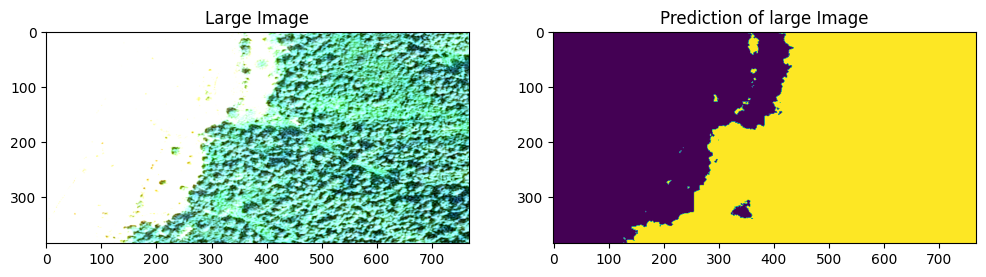

In [65]:
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Large Image')
with rasterio.open('/content/cropped_path_.tif', "r") as src:
  image = src.read([1, 2, 3]).transpose([1,2,0])
plt.imshow(image)
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image[:,:,0])
plt.show()

In [66]:
def convert_array_to_vector(binary_mask: np.array, img_path: str) -> gpd.GeoDataFrame:
    """Convert masked array to vector file(.shp).

    Args:
        binary_mask: Output predicted binary mask.
        img_path: Path of the raster file used for the prediction.

    Returns:
        shp: GeoPandas DataFrame.

    """
    with rio.open(img_path, mode='r') as src:

        # create a dict of features generator
        features = (
            {'properties': {'value': value}, 'geometry': shape}
            for (shape, value) in shapes(
                binary_mask, mask=binary_mask.astype("bool"), transform=src.transform
            )
        )

        shp = gpd.GeoDataFrame.from_features(
            features,
            crs=src.crs,  # no need to convert to string
            columns=['geometry', 'value']
        )

    return shp

In [67]:
converted_vector_file = convert_array_to_vector(reconstructed_image[:,:,0] , test_path)

In [68]:
def save_vector_file(shp: gpd.GeoDataFrame, dest_path: str) -> None:
    """Write vector file to the disk.

    Args:
        dest_path: Destionation path to save the vector file.
        shp: vector dataframe.

    """
    shp.to_file(dest_path)

In [69]:
save_vector_file(converted_vector_file, "test.shp")